In [1]:
# 기본 라이브러리 import
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler  # 표준화 스케일러(평균 0, 표준편차 1)

In [3]:
# csv 파일 불러오기
df = pd.read_csv("./data/fetch_california_housing.csv")

# df.head()
# 컬럼명 MedHouseVal -> Target
df = df.rename(columns={"MedHouseVal": "Target"})

df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Target
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


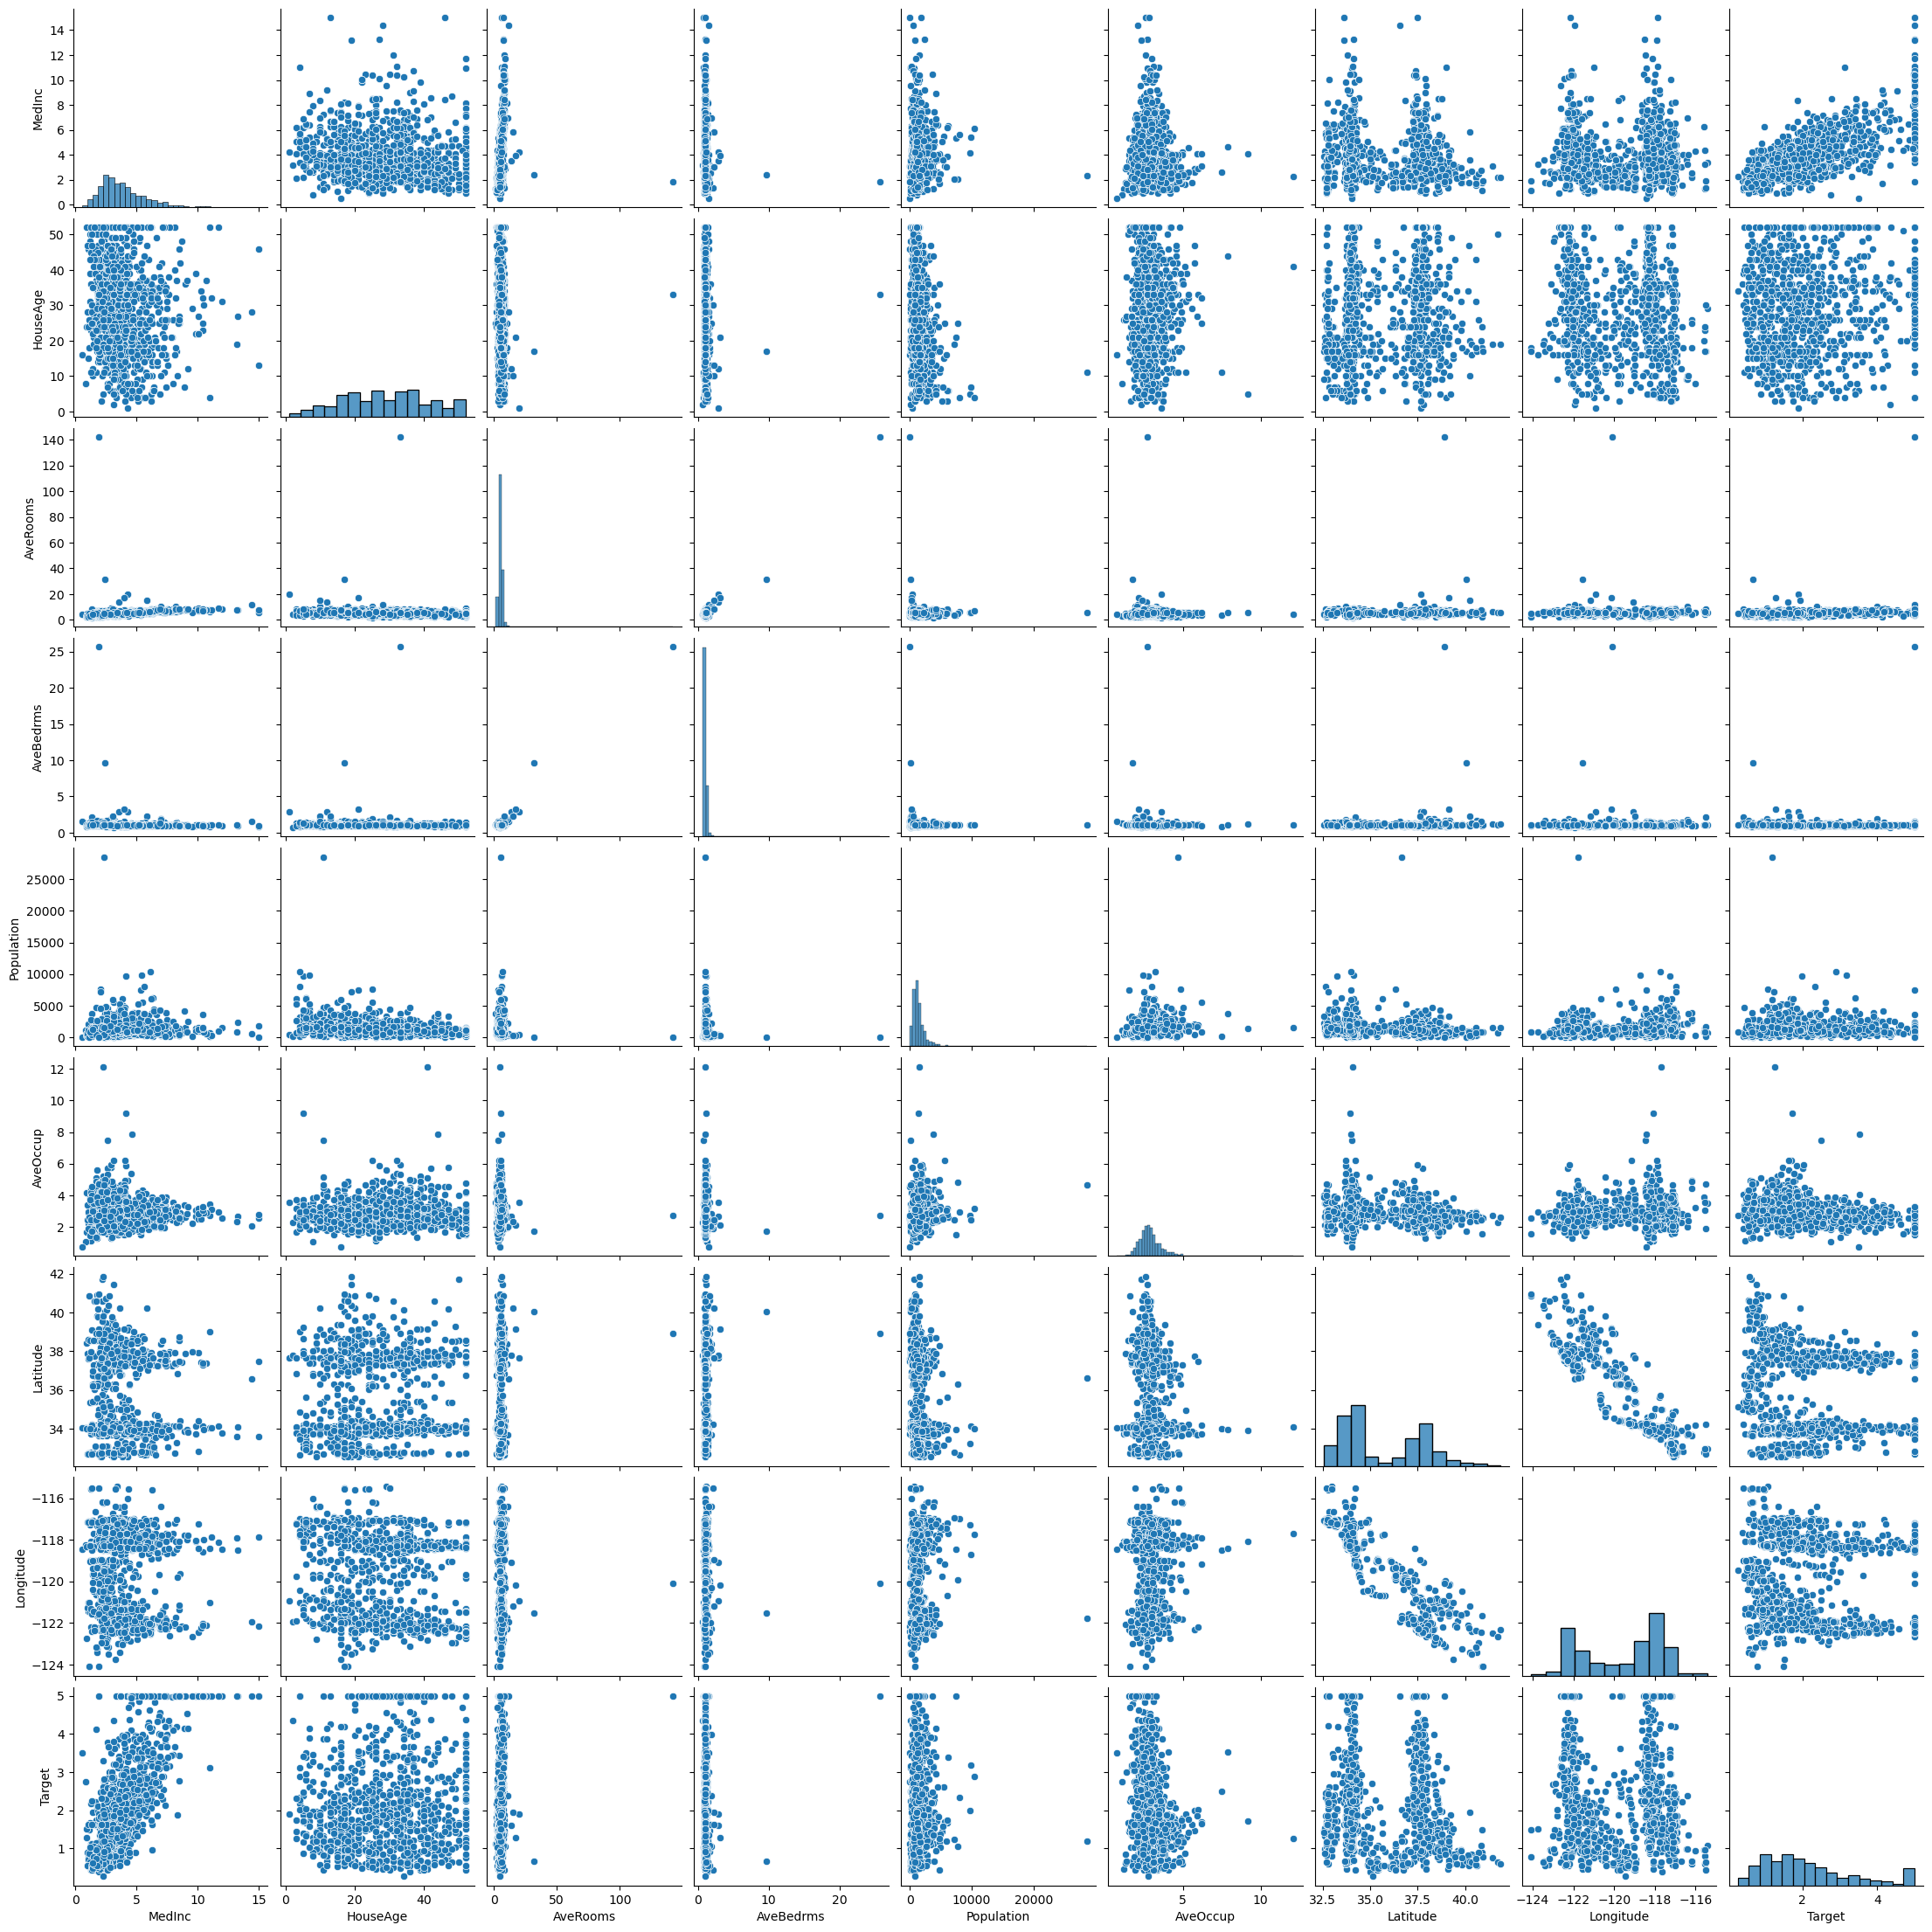

In [4]:
# 데이터 특성간 관계 시각화
sns.pairplot(df.sample(1000)) # df에서 1000개 랜덤 샘플 추출해서 상관관계를 pairplot으로 시각
plt.show()

- feature(특성) 데이터만 스케일링 적용 후 전체 데이터는 Tensor 형태로 반환

In [12]:
import torch
import numpy as np

scaler = StandardScaler()

features = df.iloc[:, :-1].values  # 마지막컬럼 제외한 컬럼
# == df[df[columns[:-1]].to_numpy()]
target = df.iloc[:, -1:].values     # 마지막 컬럼만
# == df[df[columns[-1]].to_numpy()]

print(f"features.shape : {features.shape}")
print(f"target.shape : {target.shape}")

features.shape : (20640, 8)
target.shape : (20640, 1)


In [13]:
features_scaled = scaler.fit_transform(features) # features 값을 표준화
# target_scaled = scaler.transform(target)  # target 값을 표준화

print(f"features_scaled.shape : {features_scaled.shape}")
print(f"target.shape : {target.shape}")

features_scaled.shape : (20640, 8)
target.shape : (20640, 1)


In [14]:
# (feature + target) 열 방향으로 합치기
data_np = np.concatenate([features_scaled, target], axis=1)

# numpy 배열을 Pytorch Tensor로 변환
data = torch.from_numpy(data_np).float()

print(data.size())

torch.Size([20640, 9])


In [15]:
import torch                    # Pytorch 기본 패키지
import torch.nn as nn           # 신경망 레이어/모듈
import torch.nn.functional as F # 활성화/손실함수 등 함수
import torch.optim as optim     # 최적화함

In [16]:
x = data[:, :-1]  # 특성데이터
y = data[:, -1:]  # 타겟데이터

print(x.size(), y.size())


torch.Size([20640, 8]) torch.Size([20640, 1])


In [26]:
# 하이퍼파라미터 설정
n_epochs = 4000       # 전체 학습 반복 횟수
batch_size = 256     # 미니배치 샘플 갯수
print_interval = 200  # 학습 로그 출력 간격
learning_rate = 1e-2  # 옵티마이저에 적용할 학습률

In [22]:
model = nn.Sequential(
    # 입력층 -> 은닉층
    nn.Linear(x.size(-1), 6), # 입력 특성 수 -> 은닉층1(6개 노드)
    nn.LeakyReLU(),           # LeakyReLU 활성화 함수

    nn.Linear(6, 5),          # 은닉층1 -> 은닉층2(5개 노드)
    nn.LeakyReLU(),           # LeakyReLU 활성화 함수

    nn.Linear(5, 4),          # 은닉층2 -> 은닉층3(4개 노드)
    nn.LeakyReLU(),           # LeakyReLU 활성화 함수

    nn.Linear(4, 3),          # 은닉층3 -> 은닉층4(3개 노드)
    nn.LeakyReLU(),           # LeakyReLU 활성화 함수

    nn.Linear(3, y.size(-1))  # 은닉층4 -> 출력층(1개 노드)
)

model

Sequential(
  (0): Linear(in_features=8, out_features=6, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=6, out_features=5, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=5, out_features=4, bias=True)
  (5): LeakyReLU(negative_slope=0.01)
  (6): Linear(in_features=4, out_features=3, bias=True)
  (7): LeakyReLU(negative_slope=0.01)
  (8): Linear(in_features=3, out_features=1, bias=True)
)

In [24]:
# SGD 최적화함수, (최적화 할 파라미터의 가중피 편향, lr)
optimizer = torch.optim.SGD(
    model.parameters(),   # 최적화할 파라미터(모델의 가중치, 편향)
    lr = learning_rate    # 학습률
)

optimizer

SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)

In [28]:
from tqdm.auto import tqdm

for i in tqdm(range(n_epochs), desc="Training"):
    indicies = torch.randperm(x.size(0))
    x_ = torch.index_select(x, dim = 0, index = indicies)
    y_ = torch.index_select(y, dim = 0, index = indicies)

    x_ = x_.split(batch_size, dim = 0)  # 미니배치 단위로 x_ 분할 (반환타입 : 튜플)
    y_ = y_.split(batch_size, dim = 0)  # 미니배치 단위로 y_ 분할 (반환타입 : 튜플)

    y_hat = []     # 모델의 예측값 리스트
    total_loss = 0 # 에폭별 전체 손실 누적

    for x_i, y_i in zip(x_, y_): # 미니배치 단위로 학습

        y_hat_i = model(x_i)     # 순전파 : 예측값 계산
        loss = F.mse_loss(y_hat_i, y_i) # 손실 계산 (MSE : 회귀)
        
        # 이전 배치의 기울기 초기화
        optimizer.zero_grad()

        # 역전파 : 파라미터의 기울기 계산
        loss.backward()

        # 파라미터 업데이트(SGD)
        optimizer.step()

        total_loss += float(loss)  # float 형태로 누적
        y_hat += [y_hat_i]         # 모델의 예측값 리스트에 추가
    
    total_loss = total_loss / len(x_) # 에폭별 평균 손실
    if (i + 1) % print_interval == 0:  # 200번마다 값 출력
        print(f"Epoch {i+1}/{n_epochs} | Loss: {total_loss:.4f}")

y_hat = torch.cat(y_hat, dim = 0) # 모델의 예측값 리스트를 텐서로 변환
y = torch.cat(y_, dim=0) # 정답값 리스트를 텐서로 변환

Training:   0%|          | 0/4000 [00:00<?, ?it/s]/var/folders/51/k_yn4qxs0_nfrm1hk39_0m2r0000gn/T/ipykernel_9140/3362806794.py:28: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:837.)
  total_loss += float(loss)  # float 형태로 누적
Training:   5%|▌         | 210/4000 [00:03<01:09, 54.41it/s]

Epoch 200/4000 | Loss: 0.2961


Training:  10%|█         | 406/4000 [00:07<01:07, 53.50it/s]

Epoch 400/4000 | Loss: 0.2956


Training:  15%|█▌        | 611/4000 [00:11<01:00, 56.05it/s]

Epoch 600/4000 | Loss: 0.2961


Training:  20%|██        | 805/4000 [00:15<01:01, 51.94it/s]

Epoch 800/4000 | Loss: 0.2963


Training:  25%|██▌       | 1007/4000 [00:19<00:57, 52.46it/s]

Epoch 1000/4000 | Loss: 0.2955


Training:  30%|███       | 1208/4000 [00:22<00:51, 54.30it/s]

Epoch 1200/4000 | Loss: 0.2959


Training:  35%|███▌      | 1412/4000 [00:26<00:44, 58.33it/s]

Epoch 1400/4000 | Loss: 0.2956


Training:  40%|████      | 1607/4000 [00:30<00:38, 61.81it/s]

Epoch 1600/4000 | Loss: 0.2956


Training:  45%|████▌     | 1809/4000 [00:34<00:38, 56.23it/s]

Epoch 1800/4000 | Loss: 0.2950


Training:  50%|█████     | 2007/4000 [00:37<00:38, 52.29it/s]

Epoch 2000/4000 | Loss: 0.2955


Training:  55%|█████▌    | 2209/4000 [00:41<00:33, 54.04it/s]

Epoch 2200/4000 | Loss: 0.2953


Training:  60%|██████    | 2409/4000 [00:45<00:33, 47.60it/s]

Epoch 2400/4000 | Loss: 0.2957


Training:  65%|██████▌   | 2604/4000 [00:49<00:29, 48.07it/s]

Epoch 2600/4000 | Loss: 0.2952


Training:  70%|███████   | 2806/4000 [00:53<00:23, 51.73it/s]

Epoch 2800/4000 | Loss: 0.2949


Training:  75%|███████▌  | 3009/4000 [00:57<00:19, 50.80it/s]

Epoch 3000/4000 | Loss: 0.2956


Training:  80%|████████  | 3210/4000 [01:01<00:14, 56.01it/s]

Epoch 3200/4000 | Loss: 0.2956


Training:  85%|████████▌ | 3408/4000 [01:05<00:10, 54.38it/s]

Epoch 3400/4000 | Loss: 0.2951


Training:  90%|█████████ | 3604/4000 [01:09<00:07, 50.61it/s]

Epoch 3600/4000 | Loss: 0.2948


Training:  95%|█████████▌| 3808/4000 [01:13<00:03, 51.31it/s]

Epoch 3800/4000 | Loss: 0.2955


Training: 100%|██████████| 4000/4000 [01:17<00:00, 51.80it/s]

Epoch 4000/4000 | Loss: 0.2950


.detach() : 그래디언트 추적을 끊는다. (그래프 제거)

In [29]:
df = pd.DataFrame(
    torch.cat( # (y, y_hat)을 열 방향으로 붙여 nunpy 변환
        [y, y_hat],
        dim = 1
    ).detach().numpy(),
    columns = ["y", "y_hat"] # 컬럼명 지정
)

df

,y,y_hat
0,1.38200,1.483975
1,0.86500,0.669339
2,1.36100,1.209633
3,1.61100,1.696282
4,1.18000,0.842209
...,...,...
20635,2.94900,3.645381
20636,1.70200,1.008347
20637,2.31800,1.506531
20638,1.94300,2.042810


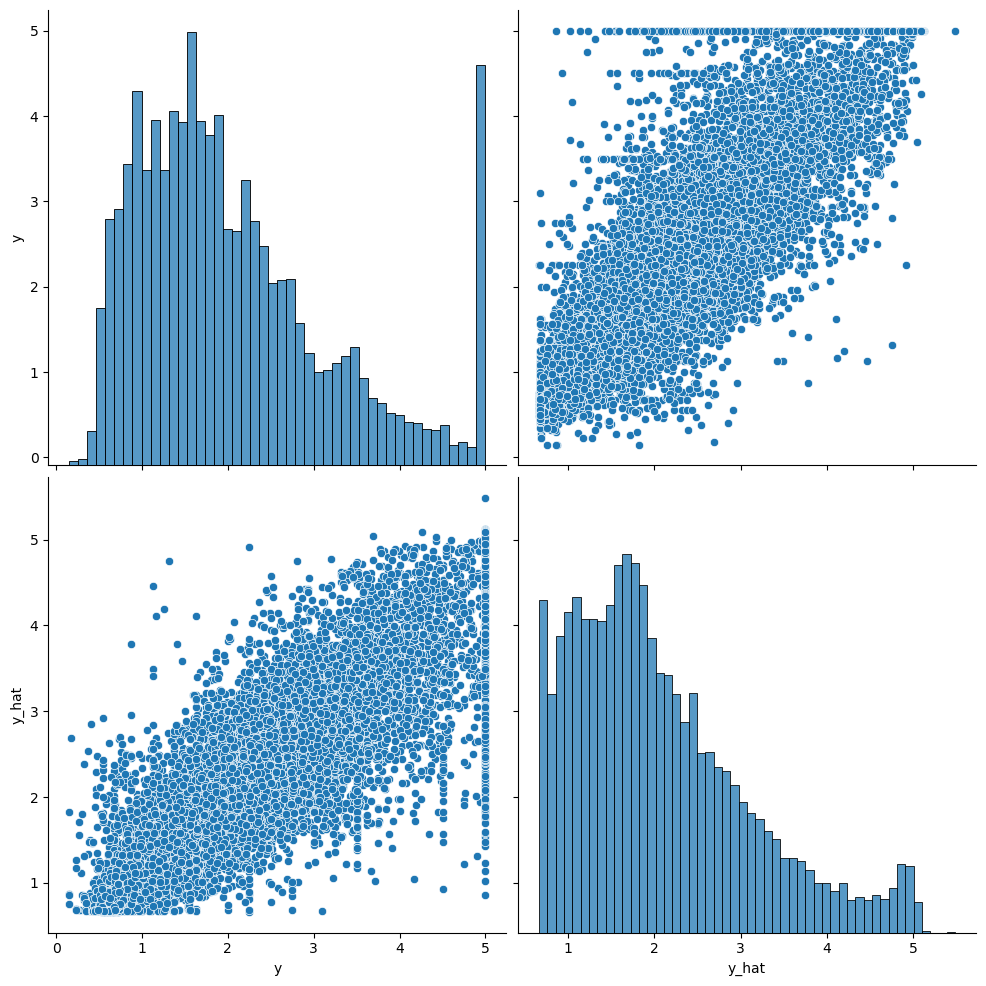

In [30]:
sns.pairplot(df, height = 5)
plt.show()